<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

 # **[MIPT DL frameworks Autumn 2024](https://wiki.cogmodel.mipt.ru/s/mtai/doc/2024-nejrosetevye-frejmvorki-glubokogo-obucheniya-ZBGd69bxLd). Class 2: Segmentation**

# Самостоятельная работа

На основе библиотеки https://github.com/qubvel-org/segmentation_models.pytorch (или любой другой, выбранной вами) реализовать файнтюнинг модели семантической/инстанс сегментации на основе предоставленный весов (ImageNet, ...). В качестве набора данных можно использовать любой датасет, домен которого отличается от предоставленных весов. Обязательно провести 3 эксперимента с вариациями https://smp.readthedocs.io/en/latest/losses.html и 2 эксперимента с https://smp.readthedocs.io/en/latest/encoders.html. LR - ReduceLROnPlateau с warmup.

В качестве отчета предоставляется репозиторий с кодом, README.md с общими комментариями и pdf лог обучения (wandb, ...). Обязательно наличие метрик сегмемнтации на валидационной/тестовой выборке до/после обучения (минимум IoU).

https://smp.readthedocs.io/en/latest/quickstart.html

In [2]:
!pip install segmentation_models_pytorch

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 77.3 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=8175954a80a9fb4a407434ad77ec3ed73eb4ab7eaab38ba9b37515dde87b5099
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60944 sha256=412b5160e683c55a608df625d9f7d484f832225038c7ae10993d50ecf87ae890
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-pytorc

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [4]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 588 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (592/592), 13.60 MiB | 15.32 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [5]:
TRAIN_DATA_PATH = '/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR = '/content'

# Select the device to train on
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define hyperparameters
EPOCHS = 10        # number of epochs
LR = 0.001         # Learning rate
IMG_SIZE = 320     # Size of image
BATCH_SIZE = 32    # Batch size

In [8]:
df = pd.read_csv(TRAIN_DATA_PATH)
print(df.shape)
df.head()

(290, 2)


,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [15]:
sample = df.iloc[np.random.randint(0, df.shape[0], size=5)]

def generate_sample_images(sample):
    imgs = sample.images

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, image in enumerate(imgs):
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        ax[i].set_title("IMAGE")
        ax[i].imshow(image)

def generate_sample_masks(sample):
    masks = sample.masks

    _, ax = plt.subplots(1, 5, figsize=(15,3))
    ax = ax.flatten()

    for i, mask in enumerate(masks):
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE) / 255.0

        ax[i].set_title("GROUND TRUTH")
        ax[i].imshow(mask, cmap='gray')

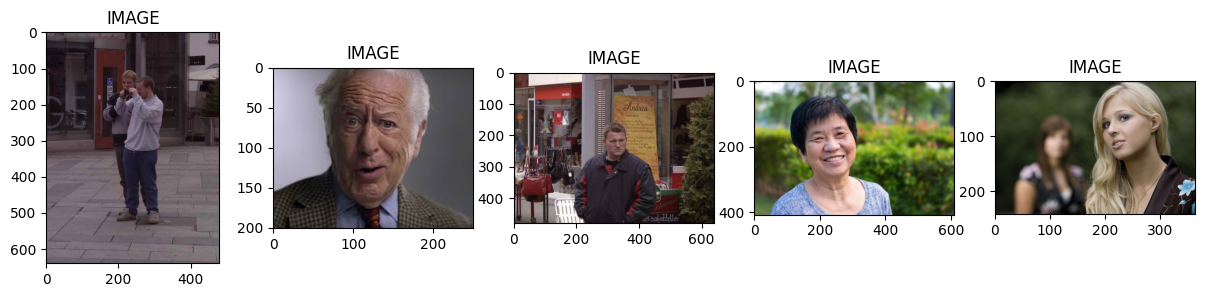

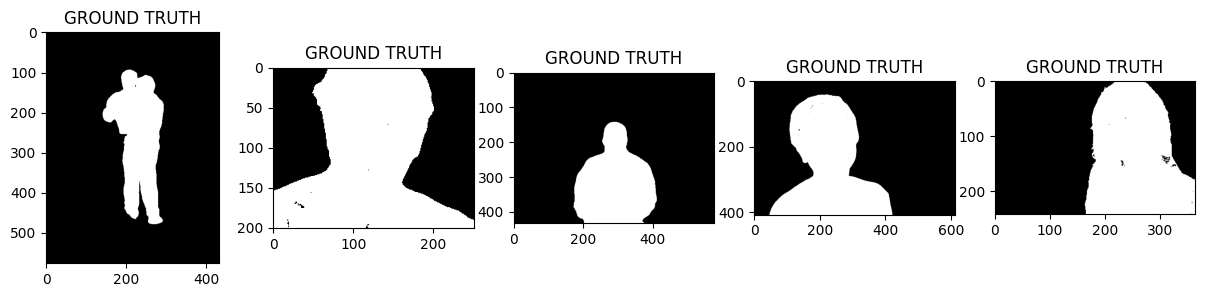

In [18]:
generate_sample_images(sample)
generate_sample_masks(sample)

In [21]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=57)

In [22]:
import albumentations as A

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.23 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [23]:
def get_train_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE),
        A.HorizontalFlip(p=0.5),      # Horizontal Flip with 0.5 probability
        A.VerticalFlip(p=0.5)         # Vertical Flip with 0.5 probability
    ], is_check_shapes=False)

def get_val_augs():
    return A.Compose([
        A.Resize(IMG_SIZE, IMG_SIZE)
    ], is_check_shapes=False)

In [24]:
from torch.utils.data import Dataset

In [25]:
class SegmentationDataset(Dataset):
    def __init__(self, df, augs):
        self.df = df
        self.augs = augs

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        image = sample.images
        mask = sample.masks

        # Read images and masks
        image = cv2.imread(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
        mask = np.expand_dims(mask, axis=-1)

        # print(f"Shapes of images before augmentation: {image.shape}")
        # print(f"Shapes of masks before augmentation: {mask.shape}")

        # Apply augmentations
        if self.augs:
            data = self.augs(image=image, mask=mask)
            image = data['image']
            mask = data['mask']

        # print(f"\nShapes of images after augmentation: {image.shape}")
        # print(f"Shapes of masks after augmentation: {mask.shape}")

        # Transpose image dimensions in pytorch format
        # (H,W,C) -> (C,H,W)
        image = np.transpose(image, (2,0,1)).astype(np.float32)
        mask = np.transpose(mask, (2,0,1)).astype(np.float32)

        # Normalize the images and masks
        image = torch.Tensor(image) / 255.0
        mask = torch.round(torch.Tensor(mask) / 255.0)

        return image, mask

In [26]:
train_data = SegmentationDataset(train_df, get_train_augs())
val_data = SegmentationDataset(val_df, get_val_augs())

In [27]:
print(f"Size of Trainset : {len(train_data)}")
print(f"Size of Validset : {len(val_data)}")

Size of Trainset : 232
Size of Validset : 58


In [28]:
def processed_image(idx):
    image, mask = train_data[idx]

    plt.subplot(1,2,1)
    plt.imshow(np.transpose(image, (1,2,0)))
    plt.axis('off')
    plt.title("IMAGE");

    plt.subplot(1,2,2)
    plt.imshow(np.transpose(mask, (1,2,0)), cmap='gray')
    plt.axis('off')
    plt.title("GROUND TRUTH");
    plt.show()

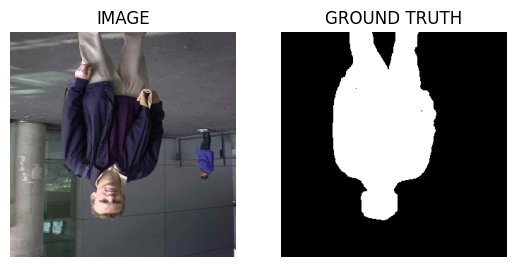

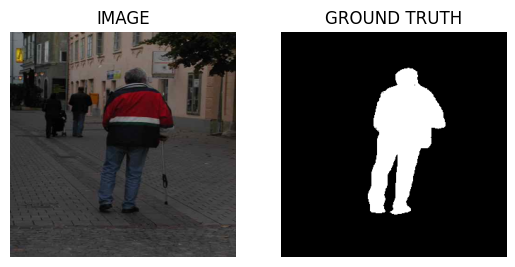

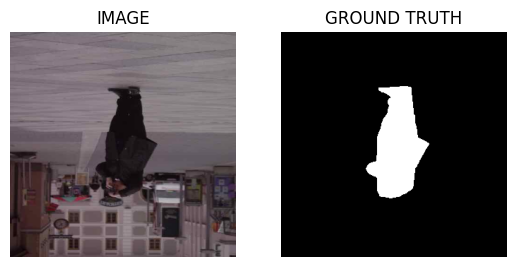

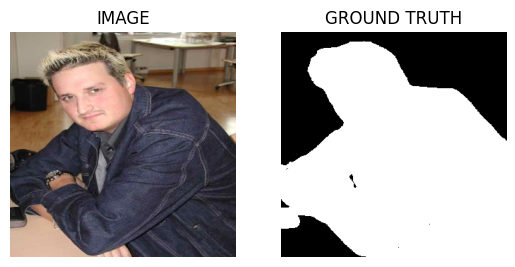

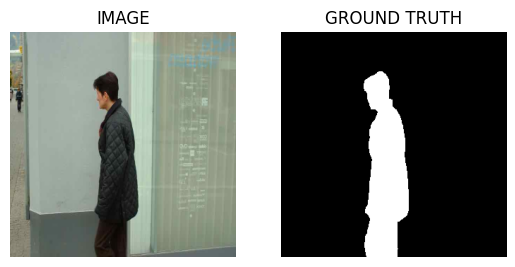

In [29]:
for i in np.random.randint(0, len(train_data), 5):
    processed_image(i)

In [30]:
from torch.utils.data import DataLoader

In [41]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Total number of batches in Train Loader: {len(trainloader)}")
print(f"Total number of batches in Val Loader: {len(valloader)}")

Total number of batches in Train Loader: 8
Total number of batches in Val Loader: 2


In [37]:
import segmentation_models_pytorch as smp
import torch

def get_model(encoder_name='resnet34', loss_function='DiceLoss'):
    model = smp.Unet(
        encoder_name=encoder_name,
        encoder_weights='imagenet',
        in_channels=3,
        classes=1,
        activation='sigmoid',
    )

    # Определение функции потерь
    if loss_function == 'DiceLoss':
        loss_fn = smp.losses.DiceLoss(mode='binary')
    elif loss_function == 'JaccardLoss':
        loss_fn = smp.losses.JaccardLoss(mode='binary')
    elif loss_function == 'FocalLoss':
        loss_fn = smp.losses.FocalLoss(mode='binary')

    return model, loss_fn


In [44]:
def calculate_iou(pred_mask, true_mask):
    pred_mask = (pred_mask > 0.5).float()
    intersection = torch.logical_and(pred_mask, true_mask).sum().float()
    union = torch.logical_or(pred_mask, true_mask).sum().float()
    iou = intersection / (union + 1e-6)  # Добавляем небольшое значение для избежания деления на 0
    return iou.item()

In [45]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import wandb

# Инициализация W&B
wandb.init(project='semantic_segmentation')

# Датасет



# Модель и функция потерь
model, loss_fn = get_model(encoder_name='resnet34', loss_function='DiceLoss')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
iou_metric = smp.metrics.iou_score
# Цикл обучения
for epoch in range(10):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()

    with torch.no_grad():
        iou_scores = []
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            outputs = (outputs > 0.5).float()
            batch_iou = [calculate_iou(pred, true) for pred, true in zip(outputs, masks)]
            iou_scores.extend(batch_iou)
    scheduler.step(val_loss)
    wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})
    print(f"Mean IoU: {torch.mean(torch.tensor(iou_scores))}")

Mean IoU: 0.31015917658805847
Mean IoU: 0.3369690179824829
Mean IoU: 0.4452971816062927
Mean IoU: 0.6532936096191406
Mean IoU: 0.7347398996353149
Mean IoU: 0.7580408453941345
Mean IoU: 0.714725911617279
Mean IoU: 0.7577031254768372
Mean IoU: 0.7430821061134338
Mean IoU: 0.6946936845779419


In [46]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import wandb

# Инициализация W&B
wandb.init(project='semantic_segmentation')

# Датасет



# Модель и функция потерь
model, loss_fn = get_model(encoder_name='resnet34', loss_function='JaccardLoss')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
iou_metric = smp.metrics.iou_score
# Цикл обучения
for epoch in range(10):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()

    with torch.no_grad():
        iou_scores = []
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            outputs = (outputs > 0.5).float()
            batch_iou = [calculate_iou(pred, true) for pred, true in zip(outputs, masks)]
            iou_scores.extend(batch_iou)
    scheduler.step(val_loss)
    wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})
    print(f"Mean IoU: {torch.mean(torch.tensor(iou_scores))}")

Mean IoU: 0.27542075514793396
Mean IoU: 0.5249455571174622
Mean IoU: 0.43039244413375854
Mean IoU: 0.6872416138648987
Mean IoU: 0.7260423302650452
Mean IoU: 0.6514589786529541
Mean IoU: 0.6904813647270203
Mean IoU: 0.6918126940727234
Mean IoU: 0.6365402340888977
Mean IoU: 0.6945042014122009


In [48]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import wandb

# Инициализация W&B
wandb.init(project='semantic_segmentation')

# Датасет



# Модель и функция потерь
model, loss_fn = get_model(encoder_name='resnet34', loss_function='FocalLoss')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
iou_metric = smp.metrics.iou_score
# Цикл обучения
for epoch in range(10):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()

    with torch.no_grad():
        iou_scores = []
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            outputs = (outputs > 0.5).float()
            batch_iou = [calculate_iou(pred, true) for pred, true in zip(outputs, masks)]
            iou_scores.extend(batch_iou)
    scheduler.step(val_loss)
    wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})
    print(f"Mean IoU: {torch.mean(torch.tensor(iou_scores))}")

Mean IoU: 0.29590359330177307
Mean IoU: 0.5278257131576538
Mean IoU: 0.6499830484390259
Mean IoU: 0.5847474932670593
Mean IoU: 0.6435883045196533
Mean IoU: 0.6920835375785828
Mean IoU: 0.6006180047988892
Mean IoU: 0.6983447074890137
Mean IoU: 0.5951403379440308
Mean IoU: 0.6791769862174988


In [49]:
import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
import wandb

# Инициализация W&B
wandb.init(project='semantic_segmentation')

# Датасет



# Модель и функция потерь
model, loss_fn = get_model(encoder_name='timm-efficientnet-b0', loss_function='DiceLoss')
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1)
iou_metric = smp.metrics.iou_score
# Цикл обучения
for epoch in range(10):
    model.train()
    train_loss = 0
    for images, masks in train_loader:
        images, masks = images.cuda(), masks.cuda()
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    val_loss = 0
    model.eval()

    with torch.no_grad():
        iou_scores = []
        for images, masks in val_loader:
            images, masks = images.cuda(), masks.cuda()
            outputs = model(images)
            loss = loss_fn(outputs, masks)
            val_loss += loss.item()
            outputs = (outputs > 0.5).float()
            batch_iou = [calculate_iou(pred, true) for pred, true in zip(outputs, masks)]
            iou_scores.extend(batch_iou)
    scheduler.step(val_loss)
    wandb.log({"train_loss": train_loss / len(train_loader), "val_loss": val_loss / len(val_loader)})
    print(f"Mean IoU: {torch.mean(torch.tensor(iou_scores))}")

Downloading: "https://github.com/huggingface/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0-0af12548.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0-0af12548.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 37.5MB/s]


Mean IoU: 0.4632525146007538
Mean IoU: 0.692970335483551
Mean IoU: 0.7927470803260803
Mean IoU: 0.8167563080787659
Mean IoU: 0.8207240700721741
Mean IoU: 0.829858660697937
Mean IoU: 0.8338035345077515
Mean IoU: 0.8483917713165283
Mean IoU: 0.8563657402992249
Mean IoU: 0.8586655855178833


Оценка:

1 балл - задание полностью соответствует критериям